In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [10]:
import warnings
warnings.filterwarnings('ignore')

import string
spec_chars = string.digits + string.punctuation + '-\n\xa0«»\t\(\)…' 

import nltk


from nltk import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from pymorphy2 import MorphAnalyzer

In [16]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian') )

[nltk_data] Downloading package stopwords to C:\Users\Andrey
[nltk_data]     Kobliakov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Andrey
[nltk_data]     Kobliakov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
import re
regex = re.compile("[А-Яа-я]+")

def len_text_sym(text):
    return len(text)

def len_text_words(text, regex=regex):
    text = " ".join(regex.findall(text))
    return len(text.split(' '))

def remove_chars_from_text(text, chars=spec_chars):
    return "".join([ch for ch in text if ch not in chars])

In [4]:
df = pd.read_json('banki_responses.json', lines = True)

df.text = df.text.str.lower()
df.city = df.city.str.lower()
df.bank_name = df.bank_name.str.lower()
df.head()
#df.drop(['city', 'bank_name', 'rating_not_checked', 'num_comments', 'bank_license', 'author', 'datetime', 'rating_grade'], axis=1, inplace=True)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. воронеж,True,Ипотека на 5+,0,лицензия № 1623,e.novikova,втб 24,2015-06-08 11:06:56,здравствуйте! хотелось бы выразить благодарно...,5.0
1,г. казань,True,ЗВОНКИ СОСЕДЯМ,0,лицензия № 2289,KZN\Vorontsova_NA,русский стандарт,2015-06-06 18:17:52,уважаемые представители департамента по работе...,2.0
2,г. санкт-петербург,True,Ложная информация!!!!,0,лицензия № 2307,Evgenia15,союз,2015-06-07 19:08:33,здравствуйте. столкнулась с такой ситуацией. в...,2.0
3,г. москва,True,Банкомат не зачислил деньги на счет,1,лицензия № 2557,dolgov.work,ситибанк,2015-06-07 19:22:00,1 июня 2015 в москве в отделении по адресу смо...,1.0
4,г. волгоград,True,Невозможно закрыть карту 2(два)!!!,0,лицензия № 3354,copLine,ренессанс кредит,2015-06-08 14:54:55,история очень долгая! пришел я в банк (это раз...,1.0


Часть 1. Анализ текстов [40/100]

Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
df_1 = df.copy() #code df for calculations
df_1.drop(['rating_not_checked', 'title', 
           'num_comments', 'bank_license', 'author', 
           'datetime', 'rating_grade'], axis=1, inplace=True)

In [6]:
df_1.dropna(subset = ['city', 'bank_name'], inplace=True) #delete from df all Nan data in city and bank_name

In [7]:
df_1.head()

,city,bank_name,text
0,г. воронеж,втб 24,здравствуйте! хотелось бы выразить благодарно...
1,г. казань,русский стандарт,уважаемые представители департамента по работе...
2,г. санкт-петербург,союз,здравствуйте. столкнулась с такой ситуацией. в...
3,г. москва,ситибанк,1 июня 2015 в москве в отделении по адресу смо...
4,г. волгоград,ренессанс кредит,история очень долгая! пришел я в банк (это раз...


In [8]:
df_1.city = df_1.city.str.replace('г\.','') #delete from cityname г. 
df_1.city = df_1.city.str.replace('ст\. ','') #delete from cityname ст. 
df_1.city = df_1.city.str.replace('обл ','область') #rename обл to область
df_1.city = df_1.city.str.replace('спб\.','санктпетербург') #rename спб to санктпетербург

In [9]:
df_1['city'] = df_1.city.apply(remove_chars_from_text)

In [10]:
df1 = df_1.groupby(['city', 'bank_name']).agg('count').reset_index().sort_values(by=['city'])
#df2 = df_1.sort_values(by=['city'], ascending=False)

In [11]:
df1

,city,bank_name,text
0,,авангард,3
1,,альфа-банк,1
2,,бинбанк кредитные карты,1
3,,русский стандарт,2
4,,русфинанс банк,1
...,...,...,...
20489,яшалта,россельхозбанк,1
20490,яшкино,совкомбанк,1
20491,яшкино,хоум кредит банк,1
20492,ёбург,сбербанк россии,1


Постройте гистограмы длин слов в символах и в словах

Гистограмма по длине слов в отзывах

In [12]:
df_2 = df.copy() #code df for calculations
df_2.drop(['rating_not_checked', 'city', 'num_comments', 
           'bank_license', 'author', 'datetime', 'title',
           'bank_name','rating_grade'], axis=1, inplace=True)
df_2.text = df_2.text.str.replace('г\.','') #delete from text г. 
df_2.text = df_2.text.str.replace('ст\.','') #delete from text ст. 
df_2.text = df_2.text.str.replace('обл\.','область') #rename text  

In [13]:
df_2['text'] = df_2.text.apply(remove_chars_from_text) #clear text from chars

In [14]:
%%time

df_2['words'] = tqdm(df_2.text.apply(word_tokenize)) #tokenized

100%|█████████████████████████████████████████████████████████████████████| 201030/201030 [00:00<00:00, 1988446.69it/s]


Wall time: 3min 25s


In [15]:
df_2['word_freq'] = df_2.words.apply(FreqDist) #dict with word frequency

In [16]:
df_2.head()

,text,words,word_freq
0,здравствуйте хотелось бы выразить благодарнос...,"[здравствуйте, хотелось, бы, выразить, благода...","{'здравствуйте': 1, 'хотелось': 1, 'бы': 1, 'в..."
1,уважаемые представители департамента по работе...,"[уважаемые, представители, департамента, по, р...","{'уважаемые': 1, 'представители': 1, 'департам..."
2,здравствуйте столкнулась с такой ситуацией в ...,"[здравствуйте, столкнулась, с, такой, ситуацие...","{'здравствуйте': 1, 'столкнулась': 1, 'с': 12,..."
3,июня в москве в отделении по адресусмоленска...,"[июня, в, москве, в, отделении, по, адресусмол...","{'июня': 2, 'в': 12, 'москве': 1, 'отделении':..."
4,история очень долгая пришел я в банк это раз ...,"[история, очень, долгая, пришел, я, в, банк, э...","{'история': 1, 'очень': 1, 'долгая': 1, 'прише..."


In [86]:
GLOBAL_DICT = {}

def len_word_count(dict1):
    for key in dict1.keys():
        if len(key) in GLOBAL_DICT.keys():
            GLOBAL_DICT[len(key)] += dict1[key]
        else:
            GLOBAL_DICT[len(key)] = dict1[key]

            
df_2.word_freq.apply(len_word_count)

0         None
1         None
2         None
3         None
4         None
          ... 
201025    None
201026    None
201027    None
201028    None
201029    None
Name: word_freq, Length: 201030, dtype: object

<AxesSubplot:>

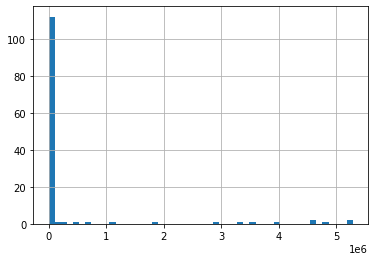

In [18]:
df_w = pd.DataFrame.from_dict(dict(sorted(GLOBAL_DICT.items(), key=lambda x: x[0])), orient='index')
#df_w.tail(20)
df_w[0].hist(bins=50)

Гистограмма по количеству слов в отзывах

In [19]:
df_2['word_len'] = df_2.words.apply(len_text_sym)

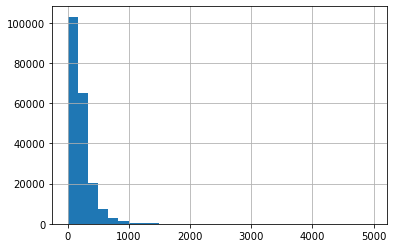

In [20]:
from matplotlib import pyplot as plt
plt.hist(df_2.word_len, bins=30)
plt.grid()
plt.show()

Найдите 10 самых частых слов

In [21]:
df_3 = df_2.copy()
df_3.drop(['word_freq', 'word_len'], axis=1, inplace=True)

In [14]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

In [24]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [25]:
df_3['wo_stop_words'] = df_3.text.apply(remove_stopwords)

In [28]:
df_3['wo_stop_words_token'] = df_3.wo_stop_words.apply(word_tokenize)

In [29]:
df_3.head()

,text,words,wo_stop_words,wo_stop_words_token
0,здравствуйте хотелось бы выразить благодарнос...,"[здравствуйте, хотелось, бы, выразить, благода...",здравствуйте хотелось выразить благодарность б...,"[здравствуйте, хотелось, выразить, благодарнос..."
1,уважаемые представители департамента по работе...,"[уважаемые, представители, департамента, по, р...",уважаемые представители департамента работе пр...,"[уважаемые, представители, департамента, работ..."
2,здравствуйте столкнулась с такой ситуацией в ...,"[здравствуйте, столкнулась, с, такой, ситуацие...",здравствуйте столкнулась ситуацией году взяла ...,"[здравствуйте, столкнулась, ситуацией, году, в..."
3,июня в москве в отделении по адресусмоленска...,"[июня, в, москве, в, отделении, по, адресусмол...",июня москве отделении адресусмоленскаясенная п...,"[июня, москве, отделении, адресусмоленскаясенн..."
4,история очень долгая пришел я в банк это раз ...,"[история, очень, долгая, пришел, я, в, банк, э...",история очень долгая пришел банк маязакрывать ...,"[история, очень, долгая, пришел, банк, маязакр..."


In [31]:
morph = MorphAnalyzer()

def make_lemmas(text):
    tokens = []
    for word in text:
        tokens.append(morph.normal_forms(word)[0])
    
    return tokens



In [32]:
%%time

df_3['wo_stop_words_lemmas'] = df_3.wo_stop_words_token.apply(make_lemmas)

Wall time: 1h 27min 26s


In [35]:
df_3.head()

,text,words,wo_stop_words,wo_stop_words_token,wo_stop_words_lemmas
0,здравствуйте хотелось бы выразить благодарнос...,"[здравствуйте, хотелось, бы, выразить, благода...",здравствуйте хотелось выразить благодарность б...,"[здравствуйте, хотелось, выразить, благодарнос...","[здравствуйте, хотеться, выразить, благодарнос..."
1,уважаемые представители департамента по работе...,"[уважаемые, представители, департамента, по, р...",уважаемые представители департамента работе пр...,"[уважаемые, представители, департамента, работ...","[уважаемый, представитель, департамент, работа..."
2,здравствуйте столкнулась с такой ситуацией в ...,"[здравствуйте, столкнулась, с, такой, ситуацие...",здравствуйте столкнулась ситуацией году взяла ...,"[здравствуйте, столкнулась, ситуацией, году, в...","[здравствуйте, столкнуться, ситуация, год, взя..."
3,июня в москве в отделении по адресусмоленска...,"[июня, в, москве, в, отделении, по, адресусмол...",июня москве отделении адресусмоленскаясенная п...,"[июня, москве, отделении, адресусмоленскаясенн...","[июнь, москва, отделение, адресусмоленскаясенн..."
4,история очень долгая пришел я в банк это раз ...,"[история, очень, долгая, пришел, я, в, банк, э...",история очень долгая пришел банк маязакрывать ...,"[история, очень, долгая, пришел, банк, маязакр...","[история, очень, долгий, прийти, банк, маязакр..."


Построим кривую Ципфа

In [71]:
ALL = []
for elem in df_2.iloc[:,1]:
    ALL +=elem

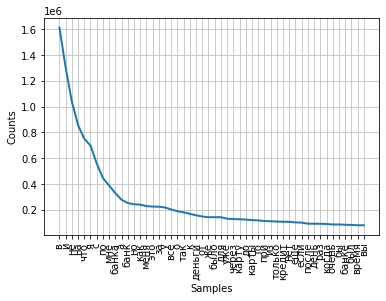

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [78]:
FreqDist(ALL).plot(50,cumulative=False)

Построим кривую Хипса

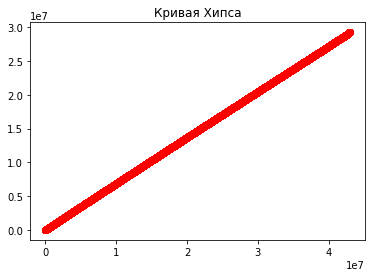

In [118]:
Y = []
X = []
prev = len(df_2.iloc[0,2])
Y.append(prev)
for i in range(1, df_2.shape[0]):
    Y.append(prev+len(df_2.iloc[i,2]))
    prev += len(df_2.iloc[i,2])

prev = len(df_2.iloc[0,1])
X.append(prev)
for i in range(1, df_2.shape[0]):
    X.append(prev+len(df_2.iloc[i,1]))
    prev += len(df_2.iloc[i,1])

    
plt.title('Кривая Хипса')
plt.plot(X,Y,'ro')
plt.show()

10 самых частых слов

In [55]:
all_word_freq = defaultdict(int)
for tokens in df_3.loc[:,'words']:
    for token in tokens:
        all_word_freq[token] += 1
sorted(all_word_freq, key=all_word_freq.get, reverse=True)[:10]

['в', 'и', 'не', 'на', 'что', 'я', 'с', 'по', 'мне', 'банка']

10 самых частых слов без стоп-слов 

In [56]:
wo_stopword_freq = defaultdict(int)
for tokens in df_3.loc[:,'wo_stop_words_token']:
    for token in tokens:
        wo_stopword_freq[token] += 1

sorted(wo_stopword_freq, key=wo_stopword_freq.get, reverse=True)[:10]

['банка',
 'банк',
 'деньги',
 'карту',
 'карты',
 'кредит',
 'день',
 'очень',
 'банке',
 'время']

10 самых частых лемм

In [57]:
lemmas_freq = defaultdict(int)
for tokens in df_3.loc[:,'wo_stop_words_lemmas']:
    for token in tokens:
        lemmas_freq[token] += 1

sorted(lemmas_freq, key=lemmas_freq.get, reverse=True)[:10]

['банк',
 'карта',
 'деньга',
 'день',
 'кредит',
 'мой',
 'который',
 'счёт',
 'отделение',
 'клиент']

10 самых частых существительных

In [58]:
noun_freq = defaultdict(int)
for tokens in df_3.loc[:,'wo_stop_words_lemmas']:
    for token in tokens:
        if morph.parse(token)[0].tag.POS == 'NOUN':
            noun_freq[token] += 1

sorted(noun_freq, key=noun_freq.get, reverse=True)[:10]

['банк',
 'карта',
 'деньга',
 'день',
 'кредит',
 'счёт',
 'отделение',
 'клиент',
 'сотрудник',
 'сумма']

Ответьте на следующие вопросы:

какое слово встречается чаще, "сотрудник" или "клиент"?

In [82]:
if noun_freq['специалист'] > noun_freq['клиент']:
    print('Слово СПЕЦИАЛИСТ встречается чаще слова КЛИЕНТ')
else:
    print('Слово СПЕЦИАЛИСТ встречается реже слова КЛИЕНТ')
print('Кол-во упоминаний слова СПЕЦИАЛИСТ: ', noun_freq['специалист'])
print('Кол-во упоминаний слова КЛИЕНТ: ', noun_freq['клиент'])

Слово СПЕЦИАЛИСТ встречается реже слова КЛИЕНТ
Кол-во упоминаний слова СПЕЦИАЛИСТ:  34645
Кол-во упоминаний слова КЛИЕНТ:  168006


сколько раз встречается слова "мошенничество" и "доверие"?

In [83]:
print('Кол-во упоминаний слова МОШЕННИЧЕСТВО: ', noun_freq['мошенничество'])
print('Кол-во упоминаний слова ДОВЕРИЕ: ', noun_freq['доверие'])

Кол-во упоминаний слова МОШЕННИЧЕСТВО:  3864
Кол-во упоминаний слова ДОВЕРИЕ:  2723


В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Подготовим 2 дата фрейма 

In [3]:
df_5 = pd.read_json('banki_responses.json', lines = True)
df_5.drop(['city', 'bank_name', 'rating_not_checked', 'num_comments', 'bank_license', 'author', 'datetime', 'title'], axis=1, inplace=True)
df_1 = df_5[df_5.rating_grade == 1.0] #датафрейм с негативными отзывами
df_5 = df_5[df_5.rating_grade == 5.0] #датафрейм с позитивными отзывами
df_1.drop(['rating_grade'], axis=1, inplace=True)
df_5.drop(['rating_grade'], axis=1, inplace=True)

Отработаем негативный датафрейм

In [8]:
df_1.text = df_1.text.str.lower()
df_1['text'] = df_1.text.apply(remove_chars_from_text) #clear text from chars
df_1['tokens'] = df_1.text.apply(word_tokenize)

Выделим ключевые слова

In [17]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0, stop_words=stopwords)
tfidf_matrix =  tfidf.fit_transform(df_1.iloc[:,0])

In [18]:
idx = np.ravel(tfidf_matrix.sum(axis=0).argsort(axis=1))[::-1][:10]
top_10_words = np.array(tfidf.get_feature_names())[idx].tolist()
top_10_words

['банка',
 'банк',
 'деньги',
 'это',
 'карту',
 'кредит',
 'карты',
 'заявление',
 'день',
 'отделение']

Выделим ключевые биграммы

In [19]:
tfidf_1_bigrams = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0, stop_words=stopwords)
tfidf_matrix_1_bigrams =  tfidf_1_bigrams.fit_transform(df_1.iloc[:,0])

idx = np.ravel(tfidf_matrix_1_bigrams.sum(axis=0).argsort(axis=1))[::-1][:10]
top_10_bigrams = np.array(tfidf_1_bigrams.get_feature_names())[idx].tolist()
top_10_bigrams

['добрый день',
 'отделение банка',
 'сих пор',
 'денежных средств',
 'денежные средства',
 'следующий день',
 'сотрудники банка',
 'кредитную карту',
 'сотрудник банка',
 'горячую линию']

Отработаем позитивный датафрейм

In [20]:
df_5.text = df_5.text.str.lower()
df_5['text'] = df_5.text.apply(remove_chars_from_text) #clear text from chars
df_5['tokens'] = df_5.text.apply(word_tokenize)

Выделим ключевые слова

In [21]:
tfidf_5_words = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0, stop_words=stopwords)
tfidf_5_matrix =  tfidf_5_words.fit_transform(df_5.iloc[:,0])

In [22]:
idx_5_words = np.ravel(tfidf_5_matrix.sum(axis=0).argsort(axis=1))[::-1][:10]
pos_top_10_words = np.array(tfidf_5_words.get_feature_names())[idx_5_words].tolist()
pos_top_10_words

['банка',
 'очень',
 'банк',
 'это',
 'кредит',
 'спасибо',
 'карту',
 'деньги',
 'банке',
 'быстро']

Выделим ключевые биграммы

In [23]:
tfidf_5_bigrams = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0, stop_words=stopwords)
tfidf_matrix_5_bigrams =  tfidf_5_bigrams.fit_transform(df_5.iloc[:,0])

In [24]:
idx_5_bigrams = np.ravel(tfidf_matrix_5_bigrams.sum(axis=0).argsort(axis=1))[::-1][:10]
pos_top_10_bigrams = np.array(tfidf_5_bigrams.get_feature_names())[idx_5_bigrams].tolist()
pos_top_10_bigrams

['являюсь клиентом',
 'хочу выразить',
 'добрый день',
 'клиентом банка',
 'выразить благодарность',
 'очень удобно',
 'большое спасибо',
 'следующий день',
 'очень быстро',
 'огромное спасибо']

Часть 2. Тематическое моделирование

Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [26]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def my_lemmatize(text):
    res = []
    for el in text.split(' '):
        res.append(morph.parse(el)[0].normal_form)
    return ' '.join(res)


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(my_lemmatize(words_only(text.lower())))

In [28]:
df = pd.read_json('banki_responses.json', lines = True)
df.drop(['city', 'bank_name', 'rating_not_checked', 'num_comments', 'bank_license', 'author', 'datetime', 'rating_grade'], axis=1, inplace=True)

In [ ]:
df.text = df.text.apply(preprocess)

CPU times: user 3h 29min 18s, sys: 24 s, total: 3h 29min 42s
Wall time: 3h 30min 4s

In [ ]:
df.to_json('my_j.json', orient='split')

In [3]:
df = pd.read_json('my_j.json', orient='split')

In [31]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

In [32]:
texts = [text.split() for text in df.text]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]



In [33]:
%%time
lsi_30 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 2min 5s


In [34]:
%%time
lsi_50 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)

Wall time: 2min 17s


In [35]:
lsi_10 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)


In [36]:
lsi_30.show_topics(5)

[(0,
  '0.199*"карта" + 0.140*"кредит" + 0.118*"деньга" + 0.110*"счёт" + 0.107*"заявление" + 0.102*"вклад" + 0.101*"отделение" + 0.100*"сумма" + 0.097*"банкомат" + 0.093*"сбербанк"'),
 (1,
  '-0.450*"вклад" + 0.332*"кредит" + -0.169*"банкомат" + -0.152*"карта" + 0.148*"платёж" + 0.147*"страховка" + 0.145*"задолженность" + 0.132*"погашение" + 0.119*"звонок" + -0.115*"открыть"'),
 (2,
  '0.440*"вклад" + -0.271*"банкомат" + -0.260*"карта" + -0.184*"сбербанк" + 0.182*"кредит" + -0.132*"операция" + -0.131*"деньга" + -0.130*"заявление" + -0.125*"средство" + 0.116*"договор"'),
 (3,
  '-0.249*"вклад" + -0.222*"сумма" + 0.210*"номер" + -0.201*"руб" + 0.166*"заявка" + -0.164*"платёж" + -0.160*"погашение" + -0.159*"договор" + -0.157*"процент" + -0.156*"комиссия"'),
 (4,
  '0.346*"вклад" + -0.297*"карта" + 0.252*"номер" + -0.190*"заявка" + 0.181*"звонок" + -0.169*"страховка" + -0.155*"лимит" + -0.141*"кредитный" + -0.131*"кредит" + 0.130*"телефон"')]

In [37]:
lsi_50.show_topics(5)

[(0,
  '0.199*"карта" + 0.139*"кредит" + 0.118*"деньга" + 0.110*"счёт" + 0.107*"заявление" + 0.102*"вклад" + 0.101*"отделение" + 0.100*"сумма" + 0.097*"банкомат" + 0.093*"сбербанк"'),
 (1,
  '-0.447*"вклад" + 0.332*"кредит" + -0.171*"банкомат" + -0.153*"карта" + 0.148*"платёж" + 0.148*"страховка" + 0.145*"задолженность" + 0.130*"погашение" + 0.120*"звонок" + -0.115*"открыть"'),
 (2,
  '0.441*"вклад" + -0.270*"банкомат" + -0.259*"карта" + -0.184*"сбербанк" + 0.180*"кредит" + -0.132*"операция" + -0.131*"деньга" + -0.130*"заявление" + -0.125*"средство" + 0.115*"договор"'),
 (3,
  '-0.243*"вклад" + -0.222*"сумма" + 0.218*"номер" + -0.201*"руб" + -0.164*"платёж" + 0.162*"заявка" + 0.160*"звонок" + -0.159*"погашение" + -0.158*"договор" + -0.156*"процент"'),
 (4,
  '0.351*"вклад" + -0.291*"карта" + 0.252*"номер" + -0.196*"заявка" + 0.179*"звонок" + -0.168*"страховка" + -0.153*"лимит" + -0.139*"кредитный" + -0.132*"кредит" + 0.129*"телефон"')]

Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [38]:
def check_bank(thems, bank_name):
    for el in thems:
        if el[1].find(bank_name) != -1:
            print(el[1])

In [39]:
check_bank(lsi_30.show_topics(), 'сбербанк')

0.199*"карта" + 0.140*"кредит" + 0.118*"деньга" + 0.110*"счёт" + 0.107*"заявление" + 0.102*"вклад" + 0.101*"отделение" + 0.100*"сумма" + 0.097*"банкомат" + 0.093*"сбербанк"
0.440*"вклад" + -0.271*"банкомат" + -0.260*"карта" + -0.184*"сбербанк" + 0.182*"кредит" + -0.132*"операция" + -0.131*"деньга" + -0.130*"заявление" + -0.125*"средство" + 0.116*"договор"
0.230*"сбербанк" + 0.224*"заявка" + 0.222*"заявление" + 0.189*"страховка" + -0.175*"платёж" + 0.153*"документ" + 0.147*"страхование" + 0.141*"договор" + -0.140*"банкомат" + 0.128*"денежный"
-0.303*"вклад" + 0.227*"перевод" + -0.196*"карта" + 0.168*"комиссия" + 0.140*"услуга" + -0.133*"заявление" + 0.124*"средство" + -0.119*"звонить" + -0.116*"позвонить" + 0.114*"сбербанк"
0.426*"банкомат" + -0.276*"сбербанк" + -0.269*"платёж" + -0.202*"перевод" + 0.153*"страховка" + 0.130*"карта" + -0.128*"счёт" + 0.125*"альфа" + 0.117*"ваш" + 0.114*"страхование"
-0.456*"страховка" + -0.200*"страхование" + -0.182*"номер" + 0.180*"кредитный" + -0.157*"

In [40]:
check_bank(lsi_30.show_topics(), 'альфа')

0.426*"банкомат" + -0.276*"сбербанк" + -0.269*"платёж" + -0.202*"перевод" + 0.153*"страховка" + 0.130*"карта" + -0.128*"счёт" + 0.125*"альфа" + 0.117*"ваш" + 0.114*"страхование"
0.271*"кошелёк" + 0.231*"терминал" + 0.222*"киви" + -0.221*"смс" + -0.198*"погашение" + -0.183*"альфа" + -0.167*"досрочный" + -0.162*"услуга" + 0.142*"лимит" + -0.131*"претензия"
0.305*"руб" + 0.234*"терминал" + -0.223*"счёт" + 0.209*"очередь" + -0.187*"деньга" + -0.178*"альфа" + 0.162*"касса" + -0.159*"перевод" + -0.132*"кредит" + 0.128*"кассир"
0.309*"перевод" + -0.225*"смс" + 0.192*"комиссия" + -0.189*"альфа" + -0.169*"документ" + 0.155*"страховка" + 0.150*"терминал" + -0.149*"договор" + 0.147*"карта" + -0.144*"услуга"
0.312*"кошелёк" + -0.305*"платёж" + 0.241*"киви" + 0.230*"справка" + 0.199*"терминал" + 0.193*"кредит" + 0.186*"руб" + 0.169*"альфа" + -0.142*"банкомат" + -0.138*"договор"
0.385*"альфа" + -0.272*"погашение" + -0.266*"досрочный" + 0.215*"счёт" + 0.197*"руб" + 0.172*"терминал" + -0.164*"комиссия

In [41]:
check_bank(lsi_30.show_topics(), 'втб')

In [42]:
check_bank(lsi_50.show_topics(), 'втб')

-0.258*"линия" + -0.255*"горячий" + 0.234*"страховка" + 0.221*"перевод" + 0.219*"задолженность" + -0.215*"договор" + -0.143*"магазин" + -0.137*"связный" + 0.137*"втб" + 0.136*"справка"
0.366*"справка" + 0.256*"ваш" + 0.199*"услуга" + 0.191*"горячий" + 0.187*"линия" + 0.149*"страхование" + -0.134*"письмо" + 0.134*"деньга" + -0.130*"задолженность" + 0.124*"втб"
0.230*"горячий" + 0.226*"линия" + -0.210*"справка" + 0.192*"ваш" + 0.190*"рубль" + -0.190*"договор" + -0.178*"курс" + -0.175*"заявление" + 0.165*"погашение" + 0.162*"втб"
0.257*"связный" + -0.207*"горячий" + -0.205*"линия" + -0.198*"заявление" + 0.188*"г" + -0.169*"втб" + 0.165*"справка" + -0.151*"операция" + -0.144*"задолженность" + 0.122*"офис"
-0.257*"претензия" + 0.233*"связный" + -0.225*"втб" + -0.215*"номер" + 0.212*"персональный" + 0.181*"альфа" + 0.166*"ваш" + 0.148*"данные" + 0.130*"менеджер" + 0.123*"сделка"
0.227*"мтс" + 0.189*"втб" + -0.187*"альфа" + 0.186*"услуга" + 0.184*"персональный" + -0.181*"реструктуризация" + -

Часть 3. Классификация текстов 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [4]:
df_full = pd.read_json('banki_responses.json', lines = True)

df_full.drop(['city', 'bank_name', 'rating_not_checked', 'num_comments', 'bank_license', 'author', 'datetime', 'text', 'title'], axis=1, inplace=True)

df_ = df.join(df_full)

df_ = df_.loc[df_['rating_grade'].isin([1.0, 5.0])]

df_['cls'] = np.where(df_.rating_grade == 1.0, 0, 1)

df_.drop(['title', 'rating_grade'], axis=1, inplace=True)

df_.head()

,text,cls
0,здравствуйте хотеться выразить благодарность б...,1
3,июнь москва отделение адрес смоленский сенной ...,0
4,история очень долгий прийти банк маязакрывать ...,0
9,хотеть поблагодарить надежда отдел ипотечный к...,1
10,интербыстробанк удобно оплачивать платёж польз...,0


In [7]:
%%time
x = df_.text
y = df_.cls
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Wall time: 16.7 ms


30 компонент ngram_range=(1,1)

In [12]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))), 
                     ('tfidf', TfidfTransformer()), 
                     ('tm', TruncatedSVD(n_components=30, random_state=0)), 
                     ('clf', RandomForestClassifier())])

In [13]:
%%time
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

Wall time: 48.8 s


In [14]:
accuracy_score(y_pred, y_test)

0.9197013281106555

30 компонент, ngram_range=(2,2)

In [19]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))), 
                     ('tfidf', TfidfTransformer()), 
                     ('tm', TruncatedSVD(n_components=30, random_state=0)), 
                     ('clf', RandomForestClassifier())])

In [20]:
%%time
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
accuracy_score(y_pred, y_test)

Wall time: 1min 57s


0.8987698145541343

30 компонент, ngram_range=(3,3)

In [5]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(3,3))), 
                     ('tfidf', TfidfTransformer()), 
                     ('tm', TruncatedSVD(n_components=30, random_state=0)), 
                     ('clf', RandomForestClassifier())])

In [8]:
%%time
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
accuracy_score(y_pred, y_test)

Wall time: 3min 24s


0.8590795030295612

Вывод: с ростом размера рассматрвиаемого элемента качество модели классификации снижается.